In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [2]:
CD8_Data = pd.read_csv("ExperimentalData/ReorganizedData_CD8.csv")

Adult_CD8_Data = CD8_Data[CD8_Data['Age Group'] == 'Adult']
Aged_CD8_Data = CD8_Data[CD8_Data['Age Group'] == 'Aged']

Adult_CD8_DPI = Adult_CD8_Data['DPI'].to_numpy()
Aged_CD8_DPI = Aged_CD8_Data['DPI'].to_numpy()

Adult_CD8_Measurements = Adult_CD8_Data['CD8+ per g/tissue'].to_numpy()
Aged_CD8_Measurements = Aged_CD8_Data['CD8+ per g/tissue'].to_numpy()

ALPHA = 0.5
t_vals = [i for i in range(0,20)]

In [3]:
#print(Adult_CD8_DPI)
#print(Aged_CD8_Data[Aged_CD8_Data["DPI"]==9])
# We want to print the number of samples in each day.
for i in Adult_CD8_Data["DPI"].unique():
    adult_size=len(Adult_CD8_Data[Adult_CD8_Data["DPI"]==i])
    aged_size = len(Aged_CD8_Data[Aged_CD8_Data["DPI"]==i])
    #print(adult_size)
    #print(aged_size)
    
    print(f"DPI {i}: Adult sample size = {adult_size}, Aged sample size = {aged_size}")
    

DPI 0: Adult sample size = 5, Aged sample size = 3
DPI 1: Adult sample size = 3, Aged sample size = 4
DPI 2: Adult sample size = 5, Aged sample size = 6
DPI 3: Adult sample size = 4, Aged sample size = 6
DPI 5: Adult sample size = 6, Aged sample size = 6
DPI 7: Adult sample size = 6, Aged sample size = 6
DPI 9: Adult sample size = 9, Aged sample size = 6
DPI 11: Adult sample size = 9, Aged sample size = 3
DPI 15: Adult sample size = 9, Aged sample size = 2
DPI 19: Adult sample size = 9, Aged sample size = 2


In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel #, RBF, WhiteKernel as Matern, C, WhiteKernel

# Define the models.
kernel_repeated = Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.5) + WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-5, 1e5))
Adult_gp = GaussianProcessRegressor(kernel=kernel_repeated, n_restarts_optimizer=100)
Aged_gp = GaussianProcessRegressor(kernel=kernel_repeated, n_restarts_optimizer=100)

# Fit the Adult model.
Adult_gp.fit(Adult_CD8_DPI.reshape(-1,1), np.log10(Adult_CD8_Measurements))
Aged_gp.fit(Aged_CD8_DPI.reshape(-1,1), np.log10(Aged_CD8_Measurements))

# Make Adult Predictions
ts = np.linspace(0, 19, 191)[:, np.newaxis]
Adult_mean, Adult_sigma = Adult_gp.predict(ts, return_std=True)
Aged_mean, Aged_sigma = Aged_gp.predict(ts, return_std=True)

NUM_SAMPLES = 50000
Adult_samples = Adult_gp.sample_y(ts, NUM_SAMPLES, 0)
Aged_samples = Aged_gp.sample_y(ts,NUM_SAMPLES,0)

#print(Aged_samples.shape)
#print(Aged_samples[:,i])

In [5]:
# Find the peak times and values
adult_peak_times_idx = np.argmax(Adult_samples, axis=0)
aged_peak_times_idx = np.argmax(Aged_samples,axis=0)

adult_peak_values = Adult_samples[adult_peak_times_idx,:]
aged_peak_values = Aged_samples[aged_peak_times_idx,:]

adult_peak_times = ts[adult_peak_times_idx]
aged_peak_times = ts[aged_peak_times_idx]

In [6]:
# Compute the percentiles of the distributions of the peak times
adult_95 = np.percentile(adult_peak_times,[2.5,50.0,97.5])
aged_95 = np.percentile(aged_peak_times,[2.5,50.0,97.5])

print(adult_95)
print(aged_95)

[ 6.8  8.9 12. ]
[10.3 15.6 18.8]


In [7]:
# Compute the probability that adult_peak < aged_peak
outcomes = [1 if adult_peak_times[i]<aged_peak_times[i] else 0 for i in range(len(adult_peak_times))]
proportion_true = sum(outcomes)/len(outcomes)
print(proportion_true)

0.92314


In [8]:
# Now, we need to approximate the downregulation rates

adult_downregulation_rates = []
aged_downregulation_rates = []

for i in range(NUM_SAMPLES):
    if adult_peak_times_idx[i] < 190: # Need to make sure we don't divide by 0.
        val = (Adult_samples[190,i]-Adult_samples[adult_peak_times_idx[i],i])/(19.0-ts[adult_peak_times_idx[i]]) #Go until the end
        adult_downregulation_rates.append(val)
    if aged_peak_times_idx[i] < 190:
        val = (Aged_samples[190,i]-Aged_samples[aged_peak_times_idx[i],i])/(19.0-ts[aged_peak_times_idx[i]]) #Go until the end
        aged_downregulation_rates.append(val)

adult_downregulation_rates = np.array(adult_downregulation_rates).reshape(-1,1)
aged_downregulation_rates = np.array(aged_downregulation_rates).reshape(-1,1)

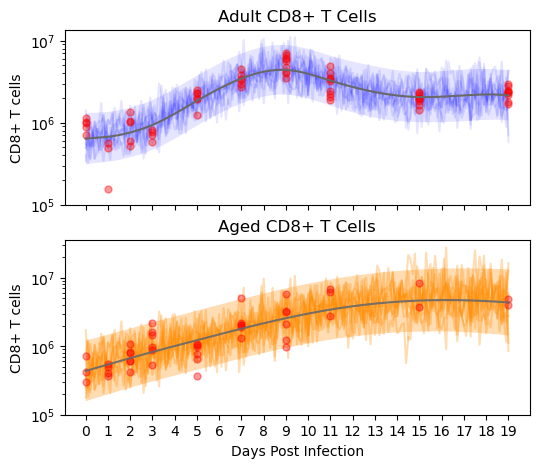

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5),sharex="col")

axs[0].set_title("Adult CD8+ T Cells")
axs[0].set_yscale('log')
axs[0].fill(np.concatenate([ts, ts[::-1]]),
         10**np.concatenate([Adult_mean - 1.9600 * Adult_sigma,
                        (Adult_mean + 1.9600 * Adult_sigma)[::-1]]),
         alpha=.1, fc='b', ec='None', label='95% Credible Interval')

for i in range(10):
    axs[0].plot(ts,10**Adult_samples[:,i],alpha=0.1, color='b')

axs[0].plot(Adult_CD8_DPI, Adult_CD8_Measurements, 'r.', alpha=0.4, markersize=10, label='Measured values')
axs[0].plot(ts, 10**Adult_mean, 'dimgrey', alpha=1.0, label='Mean Prediction')

axs[0].set_yticks([1e5,1e6,1e7])
axs[0].set_ylabel("CD8+ T cells")


axs[1].set_title("Aged CD8+ T Cells")

axs[1].set_yscale('log')
axs[1].fill(np.concatenate([ts, ts[::-1]]),
         10**np.concatenate([Aged_mean - 1.9600 * Aged_sigma,
                        (Aged_mean + 1.9600 * Aged_sigma)[::-1]]),
         alpha=.3, fc='darkorange', ec='None', label='95% Credible Interval')

for i in range(10):
    axs[1].plot(ts,10**Aged_samples[:,i],alpha=0.3, color='darkorange')
axs[1].plot(Aged_CD8_DPI, Aged_CD8_Measurements, 'r.',alpha=0.4, markersize=10, label='Measured values')
axs[1].plot(ts, 10**Aged_mean, color='dimgrey', alpha=0.9, label='Mean Prediction')

axs[1].set_yticks([1e5,1e6,1e7])

axs[1].set_ylabel("CD8+ T cells")

#axs[2].set_title("Distributions of Peaking Times")
#axs[2].hist(adult_peak_times, bins=40, alpha=0.3, density=True, label='Adult Peak Times')
#axs[2].hist(aged_peak_times,bins=40,alpha=0.3, density=True, label='Aged Peak Times')
axs[1].set_xticks(t_vals)

#axs[2].plot([adult_95[0],adult_95[2]], [0.02,0.02], color='b', alpha=0.5,linestyle='-', linewidth=2)
#axs[2].plot([adult_95[0],adult_95[0]], [0.01,0.03], color='b', alpha=0.5,linestyle='-', linewidth=2)
#axs[2].plot([adult_95[2],adult_95[2]], [0.01,0.03], color='b', alpha=0.5,linestyle='-', linewidth=2)
#axs[2].plot([adult_95[1],adult_95[1]], [0.01,0.03], color='b', alpha=0.5,linestyle='-', linewidth=2)

#axs[2].plot([aged_95[0],aged_95[2]], [0.03, 0.03], color='orange',linestyle='-', linewidth=2)
#axs[2].plot([aged_95[0],aged_95[0]], [0.02,0.04], color='orange',linestyle='-', linewidth=2)
#axs[2].plot([aged_95[2],aged_95[2]], [0.02,0.04], color='orange',linestyle='-', linewidth=2)
#axs[2].plot([aged_95[1],aged_95[1]], [0.02,0.04], color='orange',linestyle='-', linewidth=2)

#axs[1].legend()
#axs[1].set_ylabel("Relative Frequency")

axs[1].set_xlabel("Days Post Infection")

fig.savefig("GaussianProcessModel.pdf")

In [10]:
# What if we just consider at the median peaking time to the final time for each group? (This should probably work at the median)

adult_median_peak_time = adult_95[1]
aged_median_peak_time = aged_95[1]

adult_median_peak_time_idx = np.median(adult_peak_times_idx)
aged_median_peak_time_idx = np.median(aged_peak_times_idx)

adult_peak = Adult_samples[int(adult_median_peak_time_idx),:]
adult_end = Adult_samples[190,:]

aged_peak = Aged_samples[int(aged_median_peak_time_idx),:]
aged_end = Aged_samples[190,:]

adult_slopes = (adult_end - adult_peak) / (19.0-adult_median_peak_time)
print(np.median(adult_slopes))

aged_slopes = (aged_end - aged_peak) / (19.0-aged_median_peak_time)
print(np.median(aged_slopes))

adult_slopes_stats = np.percentile(adult_slopes,[2.5,50.0,97.5])
aged_slopes_stats = np.percentile(aged_slopes,[2.5,50.0,97.5])
print(adult_slopes_stats)
print(aged_slopes_stats)

-0.03083970817339959
-0.009631266507015948
[-0.07327814 -0.03083971  0.01142127]
[-0.19025155 -0.00963127  0.16901717]


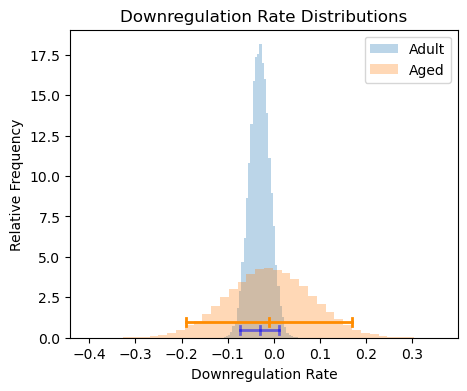

In [35]:
plt.figure(figsize=(5, 4))
plt.title("Downregulation Rate Distributions")
plt.hist(adult_slopes, bins=40, alpha=0.3, density=True, label='Adult')
plt.hist(aged_slopes,bins=40,alpha=0.3, density=True, label='Aged')
#plt.xticks([-0.3,-.25,-.2,-.15,-.1,-.05,0,.05,.1,.15,.2,.25,.3])

# These draw the 95% intervals.
plt.plot([adult_slopes_stats[0],adult_slopes_stats[2]], [0.5,0.5], color='b', alpha=0.5,linestyle='-', linewidth=2)
plt.plot([adult_slopes_stats[0],adult_slopes_stats[0]], [0.25,0.75], color='b', alpha=0.5,linestyle='-', linewidth=2)
plt.plot([adult_slopes_stats[2],adult_slopes_stats[2]], [0.25,0.75], color='b', alpha=0.5,linestyle='-', linewidth=2)
plt.plot([adult_slopes_stats[1],adult_slopes_stats[1]], [0.25,0.75], color='b', alpha=0.5,linestyle='-', linewidth=2)

plt.plot([aged_slopes_stats[0],aged_slopes_stats[2]], [1, 1], color='darkorange',linestyle='-', linewidth=2)
plt.plot([aged_slopes_stats[0],aged_slopes_stats[0]], [0.75,1.25], color='darkorange',linestyle='-', linewidth=2)
plt.plot([aged_slopes_stats[2],aged_slopes_stats[2]], [0.75,1.25], color='darkorange',linestyle='-', linewidth=2)
plt.plot([aged_slopes_stats[1],aged_slopes_stats[1]], [0.75,1.25], color='darkorange',linestyle='-', linewidth=2)

plt.ylabel("Relative Frequency")
plt.xlabel("Downregulation Rate")
plt.legend()
plt.savefig("Downregulation_Histograms.pdf")
plt.show()

In [22]:
# Now, compute the probability that adult < aged

outcomes = [1 if adult_slopes[i]<aged_slopes[i] else 0 for i in range(min([len(adult_slopes),len(aged_slopes)]))]
proportion_true = sum(outcomes)/len(outcomes)
print(proportion_true)
#print(proportion_true/(1-proportion_true))

0.60112


In [23]:
# What if we had better data, maybe leading to the case of the aged slopes being shifted version of adult slopes?
test_adult_slopes = adult_slopes+0.02 #0.02 is about the difference between the adult and aged medians.

# We need to be mix here, as otherwise we will pair each x_i with x_i + 0.02
successes = 0
drawsA = np.random.randint(0,len(adult_slopes),NUM_SAMPLES)
drawsB = np.random.randint(0,len(test_adult_slopes),NUM_SAMPLES)

adult_samples = adult_slopes[drawsA]
test_adult_samples = test_adult_slopes[drawsB]
test_outcomes = [1 if adult_samples[i]<test_adult_samples[i] else 0 for i in range(NUM_SAMPLES)]
proportion_true = sum(test_outcomes)/len(test_outcomes)
print(proportion_true)

0.74412


A combination of later peaking time and scarce data for aged mice makes it difficult to compute the downregulation rate directly.

However, if we assume samples are taken from the median of the computed peaking time distributions, then we can find the slopes to be as above. Ideally, further work could repeat the above experiments to a further time horizon with denser sampling towards the end of the experiment.

Now we want to consider estimating the posterior distribution of observed maximum of the mean trajectories given the sample sizes used.

We note that for adult mice, days 5, 7, 9, 11, 15, and 19 have at least 6 observations on each day, making it easier to estimate the downregulation rate. However, aged mice have at 6, 3, 2, 2 on days 9, 11, 15, and 19 respectively, making it much more difficult to estimate the downregulation rate with reasonable precision.

As a proxy, we consider the mean downregulation rate indicated by the mean trajectory of 2 samples for adult, and 6 samples for adult mice. This allows us to better compute sampling variability in estimates of the downregulation rate.

In [24]:
print(Aged_samples.shape)
#print(Aged_samples[:,i])
print(Adult_samples.shape)
#print(Adult_samples[:,i])

(191, 50000)
(191, 50000)


In [25]:
def sample_trajectories(trajectories, num_samples, sample_size=6):
    sampled = np.zeros((num_samples,trajectories.shape[0]))
    peak_times = []
    downregulation_slopes = []
    
    total_trajectories=trajectories.shape[1]
    
    for i in range(num_samples):
        # draw 6 random integers from trajectories
        sample_indxs = np.random.randint(total_trajectories, size=sample_size)
        sample = trajectories[:,sample_indxs]
        #print(sample)
        sample_avg = np.mean(sample,axis=1)
        #print(len(sample_avg))
        #print(sample_avg)
        max_time = np.argmax(sample_avg)
        #print(max_time/10)
        
        if max_time/10 != 19.0:
            downregulation_rate = (sample_avg[-1]-sample_avg[max_time])/(19.0 - (max_time/10))
        else:
            downregulation_rate = 0.0
        #print(downregulation_rate)
        peak_times.append(max_time/10)
        downregulation_slopes.append(downregulation_rate)
        sampled[i,:]=sample_avg
    
    return peak_times,downregulation_slopes,sampled

start = time.time()
adult_results = sample_trajectories(Adult_samples,10000,sample_size=6)
aged_results = sample_trajectories(Aged_samples,10000,sample_size=2)
end = time.time()
print(f"Time taken: {end-start}")


Time taken: 0.5289039611816406


In [26]:
#print(adult_results[0])
#print(aged_results[0])

adult_peak_95 = np.percentile(adult_results[0],[2.5,50.0,97.5])
aged_peak_95 = np.percentile(aged_results[0],[2.5,50.0,97.5])

print(adult_peak_95)
print(aged_peak_95)

[ 7.5  8.8 10.1]
[11.2975 15.8    18.8   ]


In [29]:
adult_downregulation_95 = np.percentile(adult_results[1],[2.5,50.0,97.5])
aged_downregulation_95 = np.percentile(aged_results[1],[2.5,50.0,97.5])

print(adult_downregulation_95)
print(aged_downregulation_95)

[-0.05652022 -0.04113602 -0.02696036]
[-1.42957048 -0.11941791 -0.01692405]


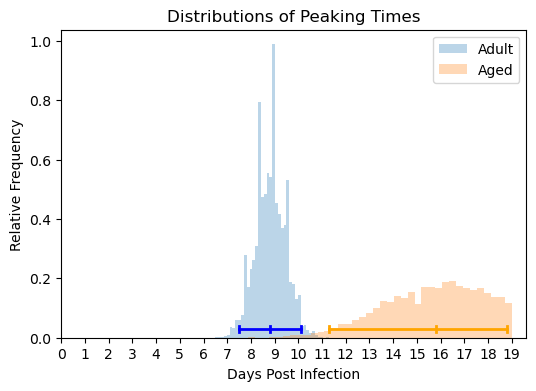

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

axs.set_title("Distributions of Peaking Times")
axs.hist(adult_results[0], bins=40, alpha=0.3, density=True, label='Adult')
axs.hist(aged_results[0],bins=40,alpha=0.3, density=True, label='Aged')

axs.plot([adult_peak_95[0],adult_peak_95[2]], [0.03, 0.03], color='b',linestyle='-', linewidth=2)
axs.plot([adult_peak_95[0],adult_peak_95[0]], [0.02,0.04], color='b',linestyle='-', linewidth=2)
axs.plot([adult_peak_95[2],adult_peak_95[2]], [0.02,0.04], color='b',linestyle='-', linewidth=2)
axs.plot([adult_peak_95[1],adult_peak_95[1]], [0.02,0.04], color='b',linestyle='-', linewidth=2)

axs.plot([aged_peak_95[0],aged_peak_95[2]], [0.03, 0.03], color='orange',linestyle='-', linewidth=2)
axs.plot([aged_peak_95[0],aged_peak_95[0]], [0.02,0.04], color='orange',linestyle='-', linewidth=2)
axs.plot([aged_peak_95[2],aged_peak_95[2]], [0.02,0.04], color='orange',linestyle='-', linewidth=2)
axs.plot([aged_peak_95[1],aged_peak_95[1]], [0.02,0.04], color='orange',linestyle='-', linewidth=2)

axs.set_xticks(t_vals)
axs.set_ylabel("Relative Frequency")
axs.legend()

axs.set_xlabel("Days Post Infection")
fig.savefig("GuassianProcessHistograms.pdf")

In [114]:
outcomes = [1 if adult_results[0][i]<aged_results[0][i] else 0 for i in range(len(adult_results[0]))]
proportion_true = sum(outcomes)/len(outcomes)
print(proportion_true)

0.9983


In [117]:
outcomes = [1 if adult_results[1][i]<aged_results[1][i] else 0 for i in range(len(adult_results[0]))]
proportion_true = sum(outcomes)/len(outcomes)
print(proportion_true)

0.0937
